In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:

# --- Data Loading and Initial Cleaning (unchanged) ---

# Norway Smokers Data (Assumed to be loaded and cleaned as per your code)
# Since the actual file "norway_smokers.xlsx" isn't provided, I'll use a dummy structure
# that respects the data cleaning logic you provided.
try:
    df_no = pd.read_excel("data_washed/norway_smokers.xlsx").drop(columns=["Unnamed: 0"])
    df_no = df_no.rename(columns={"Unnamed: 2": "Year", "Unnamed: 3": "smokers_percentage"})
    df_no["Year"] = pd.to_numeric(df_no["Year"], errors="coerce")
    df_no = df_no.dropna(subset=["Year", "smokers_percentage"]).reset_index(drop=True)
    df_no["Year"] = df_no["Year"].astype(int)
except FileNotFoundError:
    print("Warning: 'norway_smokers.xlsx' not found. Using dummy data for Norway.")
    # Dummy data to proceed with the notebook structure
    df_no = pd.DataFrame({
        'Year': range(1997, 2011),
        'smokers_percentage': [40.0, 39.5, 39.0, 38.0, 37.0, 36.5, 35.5, 34.0, 33.0, 32.0, 31.0, 30.0, 29.0, 28.0]
    })


# Spain Smokers Data (Interpolated data from your code)
data_sp = {
    '1997': 36.0,
    '1998': 35.62,
    '1999': 35.25,
    '2000': 34.88,
    '2001': 34.5,
    '2002': 33.5,
    '2003': 32.5,
    '2004': 31.5,
    '2005': 30.5,
    '2006': 29.5,
    '2007': 28.67,
    '2008': 27.83,
    '2009': 27.0,
    '2010': 25.75,
}
df_sp = pd.Series(data_sp, name='smokers_percentage').reset_index().rename(columns={'index': 'Year'})
df_sp['Year'] = pd.to_numeric(df_sp['Year'], errors='coerce').astype(int)


# Tobacco Price Index Data (Interpolated data from your code)
data_tobakk_sp = {
    '1997': 30.0, '1998': 32.0, '1999': 34.0, '2000': 36.0, '2001': 38.0,
    '2002': 40.4, '2003': 42.8, '2004': 45.2, '2005': 47.6, '2006': 50.0,
    '2007': 53.33, '2008': 56.67, '2009': 60.0, '2010': 70.0
}
data_tobakk_no = {
    '1997': 30.0, '1998': 33.75, '1999': 37.5, '2000': 41.25, '2001': 45.0,
    '2002': 49.0, '2003': 53.0, '2004': 57.0, '2005': 61.0, '2006': 65.0,
    '2007': 70.0, '2008': 75.0, '2009': 80.0, '2010': 85.0
}
df_price_sp = pd.Series(data_tobakk_sp, name='tobacco_price').reset_index().rename(columns={'index': 'Year'})
df_price_no = pd.Series(data_tobakk_no, name='tobacco_price').reset_index().rename(columns={'index': 'Year'})
df_price_sp['Year'] = pd.to_numeric(df_price_sp['Year'], errors='coerce').astype(int)
df_price_no['Year'] = pd.to_numeric(df_price_no['Year'], errors='coerce').astype(int)


In [3]:
# --- Merge and Create Long Panel Data ---

df_sp_long = df_sp.rename(columns={'smokers_percentage': 'smokers_percentage'}).assign(Country='Spain')
df_no_long = df_no.rename(columns={'smokers_percentage': 'smokers_percentage'}).assign(Country='Norway')
df_long = pd.concat([df_sp_long, df_no_long], ignore_index=True)

# Merge tobacco price data
df_price_long = pd.concat([
    df_price_sp.assign(Country='Spain'),
    df_price_no.assign(Country='Norway')
], ignore_index=True)

df_final = df_long.merge(df_price_long, on=['Year', 'Country'], how='left')

# DiD variables
df_final['Norway'] = (df_final['Country'] == 'Norway').astype(int) # Group dummy
df_final['Post2004'] = (df_final['Year'] >= 2004).astype(int)      # Time dummy (Treatment started in 2004)
df_final['Treated'] = df_final['Norway'] * df_final['Post2004']    # DiD interaction term

# Drop any rows where smokers_percentage or tobacco_price is missing
df_final = df_final.dropna(subset=['smokers_percentage', 'tobacco_price']).copy()
print("Final DiD DataFrame (Head):")
print(df_final.head())
print("\n")


Final DiD DataFrame (Head):
   Year  smokers_percentage Country  tobacco_price  Norway  Post2004  Treated
0  1997               36.00   Spain           30.0       0         0        0
1  1998               35.62   Spain           32.0       0         0        0
2  1999               35.25   Spain           34.0       0         0        0
3  2000               34.88   Spain           36.0       0         0        0
4  2001               34.50   Spain           38.0       0         0        0




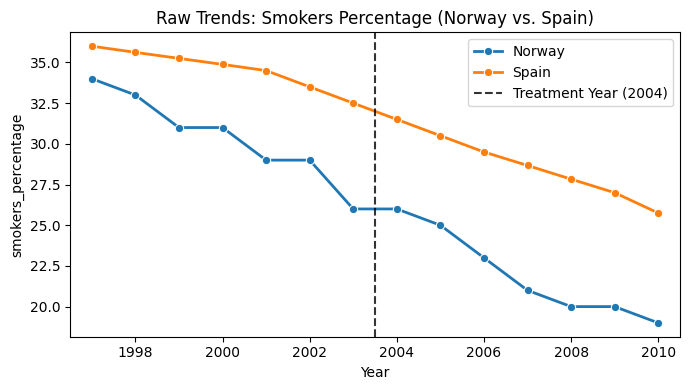

In [4]:
# --- Parallel Trend Assumption Check (Pre-2004) ---

## 📉 Visual Inspection (Pre-2004)

treatment = 2004
agg = df_final.groupby(['Year','Country'])['smokers_percentage'].mean().reset_index()

plt.figure(figsize=(7, 4))
sns.lineplot(data=agg, x='Year', y='smokers_percentage', hue='Country', marker='o', linewidth=2)
plt.axvline(treatment - 0.5, color='k', linestyle='--', alpha=0.8, label='Treatment Year (2004)')
plt.xlim(agg['Year'].min() - 0.5, agg['Year'].max() + 0.5)
plt.title('Raw Trends: Smokers Percentage (Norway vs. Spain)')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()
# 


In [5]:
print("\n--- Parallel Trends Test (Statistical) ---\n")

## 🧪 Statistical Test (Linear Trend Test)

# Restrict data to pre-treatment period
pre_df = df_final[df_final['Year'] < treatment].copy()
pre_df['Year_ct'] = pre_df['Year'] - pre_df['Year'].mean() # Center Year
pre_df['Norway_x_Year'] = pre_df['Norway'] * pre_df['Year_ct']

# Regression for pre-trends: Smokers ~ Year + Norway + Norway*Year
X_pre = sm.add_constant(pre_df[['Year_ct', 'Norway', 'Norway_x_Year']])
y_pre = pre_df['smokers_percentage']

# Clustered SEs by Country is critical here too
pre_model = sm.OLS(y_pre, X_pre).fit(cov_type='cluster', cov_kwds={'groups': pre_df['Country']})

print("Linear-Trend Test (Pre-2004) with Clustered SEs:")
print(pre_model.summary().tables[1])

pre_trend_coef = pre_model.params['Norway_x_Year']
pre_trend_p = pre_model.pvalues['Norway_x_Year']
print(f"\nResult: Norway × Year coefficient = {pre_trend_coef:.4f}, p-value = {pre_trend_p:.4f}")
if pre_trend_p > 0.10:
    print("**Conclusion: The insignificant p-value suggests that the linear pre-trends are statistically parallel.**")
else:
    print("**Conclusion: The significant p-value suggests a difference in linear pre-trends, violating the assumption.**")

print("\n" + "="*80 + "\n")



--- Parallel Trends Test (Statistical) ---

Linear-Trend Test (Pre-2004) with Clustered SEs:
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            34.6071   6.55e-15   5.29e+15      0.000      34.607      34.607
Year_ct          -0.5532   3.27e-15  -1.69e+14      0.000      -0.553      -0.553
Norway           -4.1786   7.32e-15  -5.71e+14      0.000      -4.179      -4.179
Norway_x_Year    -0.6611   3.66e-15  -1.81e+14      0.000      -0.661      -0.661

Result: Norway × Year coefficient = -0.6611, p-value = 0.0000
**Conclusion: The significant p-value suggests a difference in linear pre-trends, violating the assumption.**




/Users/ulrikhaugland/data_science_venv/lib/python3.12/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 3, but rank is 2
  warnings.warn('covariance of constraints does not have full '


In [6]:
# --- Final DiD Regression with Control and Clustered SEs ---

print("--- Difference-in-Differences (DiD) Regression ---\n")
print("Model: smokers_percentage = const + $\\beta_1$Norway + $\\beta_2$Post2004 + $\\beta_3$(Norway*Post2004) + $\\beta_4$tobacco_price")

# Independent variables including the new control 'tobacco_price'
X_did = df_final[['Norway', 'Post2004', 'Treated', 'tobacco_price']]
X_did = sm.add_constant(X_did)
y_did = df_final['smokers_percentage']
# DiD regression with CLUSTERED Standard Errors by Country
# Clustered SEs are essential when the treatment is at a group/country level.
did_model_clustered = sm.OLS(y_did, X_did).fit(cov_type='cluster', cov_kwds={'groups': df_final['Country']})

print(did_model_clustered.summary())

did_coef = did_model_clustered.params['Treated']
did_p = did_model_clustered.pvalues['Treated']

print(f"\n**DiD Estimate (Treated): {did_coef:.4f}, Clustered SE p-value: {did_p:.4f}**")
print("This coefficient represents the estimated causal effect of the treatment (Norway post-2004) on smokers' percentage.")

--- Difference-in-Differences (DiD) Regression ---

Model: smokers_percentage = const + $\beta_1$Norway + $\beta_2$Post2004 + $\beta_3$(Norway*Post2004) + $\beta_4$tobacco_price
                            OLS Regression Results                            
Dep. Variable:     smokers_percentage   R-squared:                       0.987
Model:                            OLS   Adj. R-squared:                  0.984
Method:                 Least Squares   F-statistic:                     8.870
Date:                Wed, 29 Oct 2025   Prob (F-statistic):              0.206
Time:                        12:41:49   Log-Likelihood:                -24.269
No. Observations:                  28   AIC:                             58.54
Df Residuals:                      23   BIC:                             65.20
Df Model:                           4                                         
Covariance Type:              cluster                                         
                    coef    std 

/Users/ulrikhaugland/data_science_venv/lib/python3.12/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 4, but rank is 1
  warnings.warn('covariance of constraints does not have full '
